![](https://i2.wp.com/thecleverprogrammer.com/wp-content/uploads/2020/05/Data-Science-Project-Book-Recommendation-System-with.png?resize=1024%2C576&ssl=1)

## Recommendation systems  :
are among the most popular applications of data science. They are used to predict the Rating or Preference that a user would give to an item.

Almost every major company has applied them in some form or the other: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on auto play, and Facebook uses it to recommend pages to like and people to follow.

# 1. import library and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX_Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [2]:
users = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']


In [3]:
ratings = pd.read_csv('../input/bookcrossing-dataset/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']



In [4]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


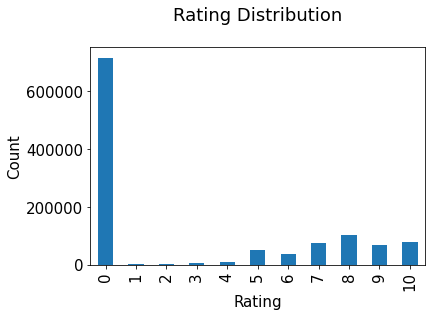

In [5]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [6]:
print(books.shape)
print(list(books.columns))

(271379, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [7]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


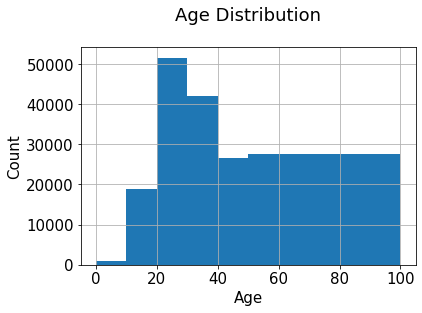

In [8]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [9]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Collaborative Filtering Using k-Nearest Neighbors (kNN)
kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user.

In [10]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
print(combine_book_rating.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  
0  Politically Correct Bedtime Stories: Modern Ta...  
1  Politically Correct Bedtime Stories: Modern Ta...  
2  Politically Correct Bedtime Stories: Modern Ta...  
3  Politically Correct Bedtime Stories: Modern Ta...  
4  Politically Correct Bedtime Stories: Modern Ta...  


## Now we will group by book titles and create a new column for total rating count.

In [11]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
print(book_ratingCount.head())

                                           bookTitle  totalRatingCount
0   A Light in the Storm: The Civil War Diary of ...                 2
1                              Always Have Popsicles                 1
2               Apple Magic (The Collector's series)                 1
3   Beyond IBM: Leadership Marketing and Finance ...                 1
4   Clifford Visita El Hospital (Clifford El Gran...                 1


### Now we will combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [12]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
print(rating_with_totalRatingCount.head())

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  
count   160587.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160587.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


In [14]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [15]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
print(rating_popular_book.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
2   11676  002542730X           6   
3   12538  002542730X          10   
4   13552  002542730X           0   

                                           bookTitle  totalRatingCount  
0  Politically Correct Bedtime Stories: Modern Ta...                82  
1  Politically Correct Bedtime Stories: Modern Ta...                82  
2  Politically Correct Bedtime Stories: Modern Ta...                82  
3  Politically Correct Bedtime Stories: Modern Ta...                82  
4  Politically Correct Bedtime Stories: Modern Ta...                82  


# Filter to users in US and Canada only

In [16]:
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
print(us_canada_user_rating.head())

   userID        ISBN  bookRating  \
0  277427  002542730X          10   
1    3363  002542730X           0   
3   12538  002542730X          10   
4   13552  002542730X           0   
5   16795  002542730X           0   

                                           bookTitle  totalRatingCount  \
0  Politically Correct Bedtime Stories: Modern Ta...                82   
1  Politically Correct Bedtime Stories: Modern Ta...                82   
3  Politically Correct Bedtime Stories: Modern Ta...                82   
4  Politically Correct Bedtime Stories: Modern Ta...                82   
5  Politically Correct Bedtime Stories: Modern Ta...                82   

                        Location  
0          gilbert, arizona, usa  
1      knoxville, tennessee, usa  
3          byron, minnesota, usa  
4        cordova, tennessee, usa  
5  mechanicsville, maryland, usa  


## Implementing kNN
We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors).

We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

In [17]:
from scipy.sparse import csr_matrix
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)
print(model_knn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [18]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
print(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1))
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
us_canada_user_rating_pivot.index[query_index]

654
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

'The Sum of All Fears (Jack Ryan Novels)'

In [19]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Sum of All Fears (Jack Ryan Novels):

1: Executive Orders (Jack Ryan Novels), with distance of 0.475603233353294:
2: Red Storm Rising, with distance of 0.6239867005197803:
3: Debt of Honor (Jack Ryan Novels), with distance of 0.6371505892071658:
4: The Cardinal of the Kremlin (Jack Ryan Novels), with distance of 0.7134283750569277:
5: Clear and Present Danger (Jack Ryan Novels), with distance of 0.7324223853633107:
